In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


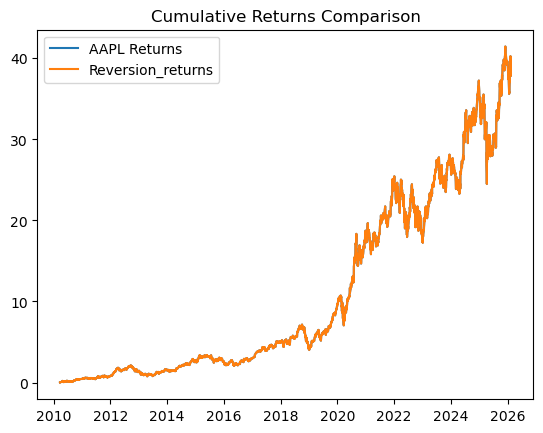

Price,Close,High,Low,Open,Volume,returns,signal,strategy,Asset_returns,strategy_returns
Date,,,,,,,,,,
2010-03-22,6.734187,6.771641,6.596357,6.605946,456419600,30.964463,1.0,NaN,NaN,NaN
2010-03-23,6.842351,6.854936,6.714709,6.760852,602431200,31.477875,1.0,1.0,0.016062,0.016062
2010-03-24,6.872614,6.897484,6.816883,6.820778,597780400,31.621521,1.0,1.0,0.020556,0.020556
2010-03-25,6.791116,6.920557,6.779130,6.919058,542284400,31.234680,1.0,1.0,0.008454,0.008454
2010-03-26,6.918458,6.949919,6.848045,6.860030,640875200,31.839125,1.0,1.0,0.027364,0.027364
...,...,...,...,...,...,...,...,...,...,...
2026-02-06,277.859985,280.647386,276.671095,276.860920,50453400,1317.888988,1.0,1.0,40.261103,40.261103
2026-02-09,274.619995,278.200012,271.700012,277.910004,44623400,1302.510065,1.0,1.0,39.779977,39.779977
2026-02-10,273.679993,275.369995,272.940002,274.890015,34376900,1298.048253,1.0,1.0,39.640390,39.640390


In [6]:
ticker = "AAPL"
LOOKBACK = -4000

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)
    df["returns"] = (1 + df['Close'].pct_change()).cumprod() - 1

    return df.iloc[LOOKBACK:,:]
    
def strategy(df):
    # 1. Create purely Buy (1) and Sell (-1) signals, use NaN for "do nothing"
    conditions = [
        (df['returns'].std() > 0), # Condition 1: Short
        (df['returns'].std() < 0)  # Condition 2: Long
    ]
    choices = [1, -1]
    
    # Use np.select to assign 1 or -1, but default to NaN (np.nan) instead of 0
    df['signal'] = np.select(conditions, choices, default=np.nan)

    # 2. Forward Fill (The Memory)
    # This says: "If today is NaN, copy yesterday's position."
    df['strategy'] = df['signal'].ffill()

    # 3. Handle the start (replace initial NaNs with 0)
    df['strategy'] = df['strategy'].fillna(0)

    # 4. Shift to trade "tomorrow"
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='Reversion_returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = strategy(df)
    df = test_strategy(df)
    return df

main()